In [438]:
import requests
import os
import json
import wptools
import time
import re
import numpy as np
import pandas as pd
from collections import Counter, OrderedDict

from matplotlib import pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_colwidth', None)


# Using Spotify's API 

... to get tracks from the '80s, their current popularity on Spotify (according to their measure) and the artist's genres.

[Guide](https://stmorse.github.io/journal/spotify-api.html) on how to use it with `requests`

In [36]:
# client and secret from the registered app - get them from env vars
CLIENT_ID = os.environ['SPOTIFY_CLIENT_ID']
CLIENT_SECRET = os.environ['SPOTIFY_CLIENT_SECRET']

# base URL of the API
BASE_URL = 'https://api.spotify.com/v1/'

In [101]:
# you need to first obtain a token from the API, for access
# this is going to expire at some point, needs regenerated
AUTH_URL = 'https://accounts.spotify.com/api/token'

# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

auth_response_data = auth_response.json()
access_token = auth_response_data['access_token']

# build the header once for all
headers = {'Authorization': 'Bearer {token}'.format(token=access_token)}

## Get '80s' tracks from the API

Due to limitations of the API, this can only get max 1000 tracks per year. However they appear to be sorted by popularity, so we're getting the bulk of the best, which is fine for our purposes

In [168]:
d_tracks = {}

In [177]:
# query tracks by year 

url = BASE_URL + 'search/'

years = range(1989, 1990)

d_tracks.update({year: [] for year in years})

for year in years:
    print(year)
    for offset in range(0, 1000, 50):
        print(offset)
        r = requests.get(BASE_URL + 'search/', 
                         params={'q': 'year:' + str(year), 
                                 'type': 'track', 
                                 'offset': str(offset),
                                 'limit': 50
                                },
                         headers=headers)
        tracks = r.json()['tracks']['items']
        #print(r.json()['tracks']['next'])
        d_tracks[year] += tracks
        if len(tracks) < 50:
            break
            

1989
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [75]:
d_tracks.keys()
[len(d_tracks[year]) for year in range(1980, 1990)]

dict_keys(['1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989'])

KeyError: 1980

In [76]:
#json.dump(d_tracks, open('tracks.json', 'w'))

In [77]:
# read in 

d_tracks_tmp = json.load(open('tracks.json'))

# years are given as strings when you read in - edit for simplicity
d_tracks = {}
for k in d_tracks_tmp:
    d_tracks[int(k)] = d_tracks_tmp[k]

Text(0.5, 1.0, 'Spotify popularity - 1980 tracks')

Text(0.5, 0, 'index track retrieved')

Text(0, 0.5, 'Popularity')

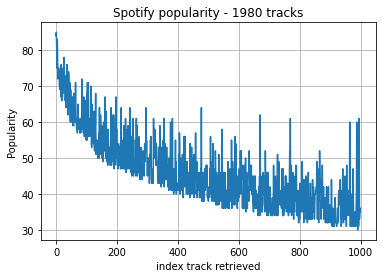

In [568]:
plt.plot(range(1000), [d_tracks[1980][i]['popularity'] for i in range(1000)])
plt.title('Spotify popularity - 1980 tracks')
plt.xlabel('index track retrieved')
plt.ylabel('Popularity')
plt.grid()

plt.savefig('popularity.jpg')

## Analyse

In [68]:
d_tracks.keys()

dict_keys(['1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989'])

In [69]:
d_tracks[1980][0].keys()

KeyError: 1980

In [188]:
d_tracks[1980][0]['artists']

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/711MCceyCBcFnzjGY4Q7Un'},
  'href': 'https://api.spotify.com/v1/artists/711MCceyCBcFnzjGY4Q7Un',
  'id': '711MCceyCBcFnzjGY4Q7Un',
  'name': 'AC/DC',
  'type': 'artist',
  'uri': 'spotify:artist:711MCceyCBcFnzjGY4Q7Un'}]

## Get all unique artists from Spotify

Note that a track can have more than one. This is to determine how many artists to display.

In [5]:
all_artists = [] # artists names
all_artists_ids = []   # same but ids, this is needed for later

for year in d_tracks.keys():
    for track in d_tracks[year]:
        for artist in track['artists']:
            all_artists.append(artist['name'])
            all_artists_ids.append(artist['id'])

In [6]:
len(all_artists), len(set(all_artists)), len(set(all_artists_ids))

(11203, 2519, 2523)

In [7]:
#artist

In [8]:
c = Counter(all_artists)

In [9]:
c.most_common(50)

[('The Cure', 93),
 ('The Smiths', 92),
 ('Metallica', 80),
 ('Johann Sebastian Bach', 70),
 ('Talking Heads', 65),
 ('U2', 62),
 ('Journey', 61),
 ('Iron Maiden', 58),
 ('Mötley Crüe', 56),
 ('Billy Joel', 54),
 ('Van Halen', 54),
 ('Bruce Springsteen', 52),
 ('Juan Gabriel', 50),
 ('Hank Williams, Jr.', 49),
 ('Prince', 49),
 ('Queen', 48),
 ('Def Leppard', 48),
 ('Alabama', 46),
 ('Stevie Ray Vaughan', 46),
 ('Oingo Boingo', 43),
 ('Los Bukis', 43),
 ('Depeche Mode', 42),
 ('Slayer', 41),
 ('AC/DC', 40),
 ('Rush', 40),
 ('Cocteau Twins', 39),
 ('Judas Priest', 38),
 ('Yo-Yo Ma', 38),
 ('Phil Collins', 37),
 ('Duran Duran', 37),
 ('Bob Marley & The Wailers', 36),
 ('George Strait', 36),
 ('Fleetwood Mac', 36),
 ('R.E.M.', 35),
 ('New Order', 34),
 ('Brian Eno', 33),
 ('Joe Hisaishi', 33),
 ('David Bowie', 32),
 ('Pixies', 32),
 ('The Police', 31),
 ('Paul Simon', 31),
 ('Glenn Gould', 31),
 ('Ozzy Osbourne', 31),
 ('Beastie Boys', 31),
 ('Genesis', 29),
 ('London Symphony Orchestra',

I mean there's Johan Sebastian so it must be a collection, let's have a looksie.. 

In [10]:
# for year in range(1980, 1990):
#     for track in d_tracks[year]:
#         for artist in track['artists']:
#             if artist['name'] == 'Johann Sebastian Bach':
#                 print(track)

turns out it's mostly Glenn Gould's Goldberg Variations, he re-recorded them in 1981.

Better I check the ones I don't know, whether they're really from the 80s...

## I think we'll do genre

can't get the genre from track itself, need to pass through the artists

Using the batch endpoint to reduce risk of 429's - you can get 50 at a time.

In [102]:
d_artists = {}    # artist: all info from API

# this one is one at a time - risks 429's
# i = 0
# for id_ in set(all_artists_ids[:]):
#     r = requests.get(BASE_URL + 'artists/' + id_, headers=headers)
#     d_artists[id_] = r.json()
        
#     if i % 10 ==0:
#         print(i)
        
#     i += 1

unique_artists = list(set(all_artists_ids))
for i in range(0, len(unique_artists), 50):
    print(i)
    
    ids = ','.join(unique_artists[i:i+50])
    time.sleep(35)
    r = requests.get(BASE_URL + 'artists/',
                     params={'ids': ids},
                     headers=headers)
    
    #print(len(r.json()['artists']))
    
    # dumping one batch at a time in case I still get 429, so previous won't get lost
    json.dump(r.json(), open('artists_{i}.json'.format(i=i), 'w'))
        

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500


In [277]:
#all_artists_ids[]

### this is not working, trying to use Wikipedia data instead

for the artists' genres. I'm getting all 429 from Spoitify now, I think it's because I've exhausted my requests with tracks search so it'd now be too slow to get artists' data. Getting this from infobox on Wikipedia

In [ ]:
d_artists_wiki_all = {}
d_artists_wiki_genres_parsed = {}

i = 0
for artist in set(all_artists):
    
    #print(artist)
    
    try:   # generic catch-all (page not exists, infobox not there, genres not in infobox)
    
        so = wptools.page(artist, silent=True, verbose=False).get_parse()
        infobox = so.data['infobox']

        if infobox:

            d_artists_wiki_all[artist] = infobox

            
            genre_str = infobox['genre'] 
            tmp = re.findall('\[\[.*\]\]', genre_str)
            genres = [item.replace('[[', '').replace(']]', '').split('|')[0] for item in tmp]

            d_artists_wiki_genres_parsed[artist] = genres

    except:
        pass 
    
    if i % 10 == 0:
        print(i)
    i += 1
    
json.dump(d_artists_wiki_all, open('artists_all.json', 'w'))
json.dump(d_artists_wiki_genres_parsed, open('artists_genres.json', 'w'))
            

API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


0


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


10


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


20


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wik

30


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


40
50


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


60


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


70


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


80


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


90


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


100
110


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


120


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


130


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


140


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


150


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


160
170


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


180


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


190


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wik

200
210


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


220


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


230


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wik

240


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


250


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


260


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


270


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wik

280


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


290


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


300
310
320
330


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


340
350


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


360
370


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


380


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


390


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


400


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


410
420


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wik

430


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


440


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


450
460


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


470


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wik

480


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wik

490


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


500
510


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


520
530


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wik

540
550


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wik

560


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


570


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


580


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


590


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


600
610


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


620
630


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wik

640
650


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


660


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


670


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


680


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


690


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


700


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


710
720


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


730
740


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


750
760


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


770


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


780
790


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


800


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


810


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


820


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


830


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


840


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


850
860
870


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


880


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


890
900
910


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


920


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


930
940


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


950


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


960


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wik

970


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


980


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wik

990


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wik

1000


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


1010


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


1020


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


1030
1040


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


1050
1060
1070


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


1080
1090
1100


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


1110


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


1120


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


1130
1140


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


1150
1160
1170


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


1180


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


1190


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


1200


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


1210


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


1220


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wik

1230


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


1240


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


1250


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


In [14]:
len(d_artists_wiki_genres_parsed)

1300

In [29]:
so = wptools.page('Queen', silent=True, verbose=False).get_parse()

In [30]:
so.data

{'requests': ['parse'],
 'iwlinks': ['https://en.wiktionary.org/wiki/Queen',
  'https://en.wiktionary.org/wiki/queen'],
 'pageid': 25180,
 'wikitext': '{{pp-semi-indef|small=yes}}\n{{Wiktionary|Queen|queen}}\n\'\'\'Queen\'\'\' or \'\'\'QUEEN\'\'\' may refer to:<!--Do not add entries that are not commonly referred to simply as "Queen" -->\n\n== Monarchy ==\n* [[Queen regnant]], a female monarch of a Kingdom\n** [[List of queens regnant]]\n* [[Queen consort]], the wife of a reigning king\n* [[Queen dowager]], the widow of a king\n* [[Queen mother]], a queen dowager who is the mother of a reigning monarch\n\n== Arts and entertainment ==\n===Fictional characters=== <!--Queen (character) redirects here-->\n* [[Queen (Marvel Comics)]], Adrianna "Ana" Soria\n* [[Evil Queen]], from \'\'Snow White\'\'\n* [[Red Queen (Through the Looking-Glass)|Red Queen (\'\'Through the Looking-Glass\'\')]]\n* [[Queen of Hearts (Alice\'s Adventures in Wonderland)|Queen of Hearts (\'\'Alice\'s Adventures in Wond

In [28]:
# check the ones we couldn't find on wiki
for artist in c:
    if artist not in d_artists_wiki_all:
        print(artist)

Queen
Journey
38 Special
Rush
Pretenders
Ambrosia
Genesis
Johnny Lee
Eagles
Lakeside
Zapp
Blondie
Carlos Y Jose
Ramon Ayala Y Sus Bravos Del Norte
Los Baron De Apodaca
Squeeze
Christopher van Kampen
Cristina Ortiz
Tom Browne
L.T.D.
Visage
The Outlaws
CASIOPEA
John Anderson
Mioko Yamaguchi
Eugene Bowen
Prince
Wipers
Archie James Cavanaugh
Robert Palmer
Ramón Torres
Madness
John Barry
Agustin Pereyra Lucena
Change
Johnny Otis & His Orchestra
Rachel Elkind
Kano
Les Ladd
Georgie Fame & The Blue Flames
Grupo Ladron
Cameo
Roberto De Carvalho
Larsen/Feiten Band
The London Opera Chorus
National Philharmonic Orchestra
Giuliano Sorgini
Breakwater
Jerry Legrand
Harlequin
Bryan Bowers
Denise De Kalafe
Airplay
EPO
Juan Bautista
William Walton
Invisible Man's Band
Balla Et Ses Balladins
Feroz Khan
Michael Miglio
Lucho Argain
Dynasty
KISS
Monchy Capricho
The Tallis Scholars
Kenny Knight
Minutemen
Los Humildes
Vera
Rev. Cleveland James Choir
Michael Franks
El Gran Combo De Puerto Rico
Peter Green
TP F

Problem is, some are not found because of a slight name difference, but also for many the infobox is npt parsed correctly and the genre field is not identified - we'd have to parse it ourselves from the raw text we get. Going back to Spotify to see if it gives me the data (maybe with enough time in between batches of requests this will work now).

## Check Spotify's artists data

In [103]:
l_s_artists = []
for i in range(0, 2550, 50):
    print(i)
    l_s_artists += json.load(open('artists_{}.json'.format(i), 'r'))['artists']

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500


In [104]:
len(l_s_artists)

2523

In [105]:
l_s_artists[10]

{'external_urls': {'spotify': 'https://open.spotify.com/artist/6bR0cgMtkCVpm0I5yrDNzO'},
 'followers': {'href': None, 'total': 168859},
 'genres': ['acoustic blues',
  'blues',
  'harmonica blues',
  'rhythm and blues',
  'texas blues',
  'traditional blues'],
 'href': 'https://api.spotify.com/v1/artists/6bR0cgMtkCVpm0I5yrDNzO',
 'id': '6bR0cgMtkCVpm0I5yrDNzO',
 'images': [{'height': 640,
   'url': 'https://i.scdn.co/image/ab67616d0000b273f25345e400eb77c2d49f8558',
   'width': 640},
  {'height': 300,
   'url': 'https://i.scdn.co/image/ab67616d00001e02f25345e400eb77c2d49f8558',
   'width': 300},
  {'height': 64,
   'url': 'https://i.scdn.co/image/ab67616d00004851f25345e400eb77c2d49f8558',
   'width': 64}],
 'name': 'Big Mama Thornton',
 'popularity': 43,
 'type': 'artist',
 'uri': 'spotify:artist:6bR0cgMtkCVpm0I5yrDNzO'}

## Link songs to artists via the genre

first add all genres (from all artists and all there are) to track, in order of appearance (there can be more artists and more genres per artist)

In [106]:
l_s_artists[0]

{'external_urls': {'spotify': 'https://open.spotify.com/artist/5S3BxZrK4hYN3fwsw8oumq'},
 'followers': {'href': None, 'total': 491500},
 'genres': ['salsa', 'salsa puertorriquena'],
 'href': 'https://api.spotify.com/v1/artists/5S3BxZrK4hYN3fwsw8oumq',
 'id': '5S3BxZrK4hYN3fwsw8oumq',
 'images': [{'height': 640,
   'url': 'https://i.scdn.co/image/ab6761610000e5eb93a3adae34178f1cee4da912',
   'width': 640},
  {'height': 320,
   'url': 'https://i.scdn.co/image/ab6761610000517493a3adae34178f1cee4da912',
   'width': 320},
  {'height': 160,
   'url': 'https://i.scdn.co/image/ab6761610000f17893a3adae34178f1cee4da912',
   'width': 160}],
 'name': 'Ismael Miranda',
 'popularity': 48,
 'type': 'artist',
 'uri': 'spotify:artist:5S3BxZrK4hYN3fwsw8oumq'}

In [107]:
type(d_tracks[1980][0])
d_tracks[1980][0]['artists']

dict

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/711MCceyCBcFnzjGY4Q7Un'},
  'href': 'https://api.spotify.com/v1/artists/711MCceyCBcFnzjGY4Q7Un',
  'id': '711MCceyCBcFnzjGY4Q7Un',
  'name': 'AC/DC',
  'type': 'artist',
  'uri': 'spotify:artist:711MCceyCBcFnzjGY4Q7Un'}]

In [263]:
# first build a quick lookup artist-genres for convenience
# uses artist's ID and another for name

d_artists_genres, d_artists_genres_name = {}, {}
for artist in l_s_artists:
    # if artist['id'] in d_artists_genres:
    #     print(artist['id'])
    d_artists_genres[artist['id']] = artist['genres']
    d_artists_genres_name[artist['name']] = artist['genres']

In [109]:
for year in d_tracks:
    for track in d_tracks[year]:
        for artist in track['artists']:
            track['genres'] = d_artists_genres[artist['id']]

In [110]:
len(d_artists_genres), len(l_s_artists), len(set([artist['id'] for artist in l_s_artists]))

(2523, 2523, 2523)

In [128]:
d_tracks[1980][100]['artists']
d_tracks[1980][100]['genres']

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/2QsynagSdAqZj3U9HgDzjD'},
  'href': 'https://api.spotify.com/v1/artists/2QsynagSdAqZj3U9HgDzjD',
  'id': '2QsynagSdAqZj3U9HgDzjD',
  'name': 'Bob Marley & The Wailers',
  'type': 'artist',
  'uri': 'spotify:artist:2QsynagSdAqZj3U9HgDzjD'}]

['reggae', 'roots reggae']

In [129]:
d_artists_genres['2QsynagSdAqZj3U9HgDzjD']

['reggae', 'roots reggae']

## Now analyse data for vizzing

### most common genres

In [139]:
# most common genres
# first genres is the first in the list

all_genres, first_genres = [], []
for year in d_tracks:
    for track in d_tracks[year]:
        all_genres += track['genres']
        if len(track['genres']) > 0:
            first_genres.append(track['genres'][0])

In [149]:
for year in d_tracks:
    for track in d_tracks[year]:
        if 'soft rock' in track['genres']:
            print(track['name'], track['artists'][0]['name'])

You Make My Dreams (Come True) Daryl Hall & John Oates
Any Way You Want It Journey
Hit Me With Your Best Shot Pat Benatar
It's Still Rock and Roll to Me Billy Joel
Keep on Loving You REO Speedwagon
Hold On Loosely 38 Special
Take It On the Run REO Speedwagon
What I Like About You The Romantics
Against The Wind Bob Seger
I'm Coming Out Diana Ross
Hey Nineteen Steely Dan
You May Be Right Billy Joel
Brass in Pocket - 2006 Remaster Pretenders
Biggest Part of Me Ambrosia
All Out of Love Air Supply
Kiss on My List Daryl Hall & John Oates
Misunderstanding Genesis
Don't Ask Me Why Billy Joel
Guilty (feat. Barry Gibb) Barbra Streisand
Seven Bridges Road - Live; 1999 Remaster Eagles
You'll Accomp'ny Me Bob Seger
Upside Down Diana Ross
Love the One You're With Crosby, Stills & Nash
Drivin' My Life Away Eddie Rabbitt
You're the Only Woman - You & I Ambrosia
Ain't Even Done With The Night John Mellencamp
Fire Lake Bob Seger
Her Strut Bob Seger
Turn Me Loose Loverboy
Lost In Love Air Supply
Late in 

In [140]:
len(all_genres), len(set(all_genres)), len(first_genres), len(set(first_genres))

(43932, 879, 9549, 466)

In [156]:
c_g = Counter(all_genres)
c_g.most_common(20)

[('rock', 2655),
 ('album rock', 1812),
 ('classic rock', 1617),
 ('hard rock', 1603),
 ('soft rock', 1503),
 ('new wave', 1218),
 ('mellow gold', 1099),
 ('new wave pop', 999),
 ('new romantic', 983),
 ('permanent wave', 975),
 ('singer-songwriter', 799),
 ('heartland rock', 785),
 ('glam metal', 766),
 ('synthpop', 679),
 ('metal', 598),
 ('country rock', 585),
 ('alternative rock', 546),
 ('country', 526),
 ('punk', 484),
 ('quiet storm', 431)]

In [ ]:
for year in d_tracks:
    for track in d_tracks[year]:
        if 'rock' in 

### most common artists and their timeline with popularities

In [161]:
c_a = Counter(all_artists)

In [162]:
c_a.most_common()

[('The Cure', 93),
 ('The Smiths', 92),
 ('Metallica', 80),
 ('Johann Sebastian Bach', 70),
 ('Talking Heads', 65),
 ('U2', 62),
 ('Journey', 61),
 ('Iron Maiden', 58),
 ('Mötley Crüe', 56),
 ('Billy Joel', 54),
 ('Van Halen', 54),
 ('Bruce Springsteen', 52),
 ('Juan Gabriel', 50),
 ('Hank Williams, Jr.', 49),
 ('Prince', 49),
 ('Queen', 48),
 ('Def Leppard', 48),
 ('Alabama', 46),
 ('Stevie Ray Vaughan', 46),
 ('Oingo Boingo', 43),
 ('Los Bukis', 43),
 ('Depeche Mode', 42),
 ('Slayer', 41),
 ('AC/DC', 40),
 ('Rush', 40),
 ('Cocteau Twins', 39),
 ('Judas Priest', 38),
 ('Yo-Yo Ma', 38),
 ('Phil Collins', 37),
 ('Duran Duran', 37),
 ('Bob Marley & The Wailers', 36),
 ('George Strait', 36),
 ('Fleetwood Mac', 36),
 ('R.E.M.', 35),
 ('New Order', 34),
 ('Brian Eno', 33),
 ('Joe Hisaishi', 33),
 ('David Bowie', 32),
 ('Pixies', 32),
 ('The Police', 31),
 ('Paul Simon', 31),
 ('Glenn Gould', 31),
 ('Ozzy Osbourne', 31),
 ('Beastie Boys', 31),
 ('Genesis', 29),
 ('London Symphony Orchestra',

In [163]:
for year in d_tracks:
    for track in d_tracks[year]:
        for artist in track['artists']:
            if artist['name']=='The Cure':
                print(year, track['name'], track['popularity'])

1980 A Forest - 2006 Remaster 60
1980 Play for Today - 2006 Remaster 55
1980 M - 2006 Remaster 55
1980 A Forest - 2006 Remaster 40
1980 At Night - 2006 Remaster 41
1980 In Your House - 2006 Remaster 37
1980 Secrets - 2006 Remaster 37
1980 Seventeen Seconds - 2006 Remaster 34
1980 Play for Today - 2006 Remaster 34
1980 A Reflection - 2006 Remaster 33
1980 Three - 2006 Remaster 32
1980 I Dig You 31
1981 Charlotte Sometimes - Single Version 52
1981 Primary - 2005 Remaster 47
1981 Faith - 2005 Remaster 35
1981 The Funeral Party - 2005 Remaster 35
1981 Primary - 2005 Remaster 34
1981 The Funeral Party - 2005 Remaster 34
1981 All Cats Are Grey - 2005 Remaster 34
1981 The Holy Hour - 2005 Remaster 33
1981 All Cats Are Grey - 2005 Remaster 32
1981 Doubt - 2005 Remaster 31
1981 Other Voices - 2005 Remaster 31
1982 One Hundred Years - 2005 Remaster 49
1982 Cold - 2005 Remaster 49
1982 The Hanging Garden - 2005 Remaster 43
1982 A Strange Day - 2005 Remaster 42
1982 Siamese Twins - 2005 Remaster 3

In [204]:
# timeline year by year
    
for year in d_tracks:
    print('\n')
    print(year)
    for track in d_tracks[year]:
        for artist in track['artists']:
#            print(artist['name'])
            if artist['name'] in [item[0] for item in c_a.most_common(20)]:
                print(artist['name'], track['popularity'], track['name'])



1980
Queen 75 Another One Bites The Dust - Remastered 2011
Queen 72 Crazy Little Thing Called Love - Remastered 2011
Journey 75 Any Way You Want It
Billy Joel 73 It's Still Rock and Roll to Me
Alabama 70 Song of the South
Hank Williams, Jr. 67 Dinosaur
Alabama 67 I'm in a Hurry (And Don't Know Why)
Talking Heads 70 Once in a Lifetime - 2005 Remaster
Billy Joel 66 You May Be Right
Alabama 64 Mountain Music
Bruce Springsteen 71 Hungry Heart
Alabama 61 Dixieland Delight - Single Edit
The Cure 60 A Forest - 2006 Remaster
Billy Joel 63 Don't Ask Me Why
Queen 60 Another One Bites The Dust
Hank Williams, Jr. 59 The American Way
Alabama 60 High Cotton
Alabama 59 If You're Gonna Play in Texas (You Gotta Have a Fiddle in the Band)
Talking Heads 58 Once in a Lifetime
The Cure 55 Play for Today - 2006 Remaster
The Cure 55 M - 2006 Remaster
Alabama 54 Born Country
Van Halen 54 And the Cradle Will Rock... - 2015 Remaster
U2 60 I Will Follow - Remastered 2008
Bruce Springsteen 68 The River
Hank Wil

### Most popular artists overall

Popular based on Spotify's popularity score - avg across all their tracks

In [170]:
d_artists_scores = {artist: [] for artist in list(set(all_artists))}

for year in d_tracks:
    for track in d_tracks[year]:
        for artist in track['artists']:
            d_artists_scores[artist['name']].append(track['popularity'])

In [176]:
# check
len(d_artists_scores['AC/DC'])
len([item for item in all_artists if item=='AC/DC'])

40

40

In [193]:
d_artists_scores_stats = {
    artist: {'avg_score': np.mean(d_artists_scores[artist]),
             'n_tracks': len(d_artists_scores[artist])}
    for artist in d_artists_scores}

In [196]:
d_artists_scores_stats['Katrina & The Waves']

{'avg_score': 81.0, 'n_tracks': 1}

In [264]:
d_artists_genres_name['AC/DC']

['australian rock', 'hard rock', 'rock']

### Artists of the most popular songs, year by year 

In [250]:
track_names, track_years, track_scores, track_artists = [], [], [], []
for year in d_tracks:
    for track in d_tracks[year]:
        track_names.append(track['name'])
        track_years.append(year)
        track_scores.append(track['popularity'])
        track_artists.append(' '.join([a['name'] for a in track['artists']]))
    
tracks_df = pd.DataFrame({'track': track_names, 
                          'year': track_years, 
                          'score': track_scores,
                          'artists': track_artists})

In [429]:
# also a DF for artists's genres

genres_df = pd.DataFrame({'artist': d_artists_genres_name.keys(), 
                        'genres': [','.join(d_artists_genres_name[k]) for k in d_artists_genres_name.keys()]})

In [564]:
genres_df[genres_df.artist=="Skid Row" ]

,artist,genres
626,Skid Row,"album rock,glam metal,hard rock,metal,rock"


In [454]:
year = 1981

tracks_df[tracks_df.year==year].sort_values('score', ascending=False).head(50)

# df_tmp

# l_ = [a for a in df_tmp['artists']]

# len(l_), len(set(l_))
# set(l_)

,track,year,score,artists
1000,Don't Stop Believin',1981,84,Journey
1004,Tainted Love,1981,81,Soft Cell
1005,Start Me Up - Remastered 2009,1981,80,The Rolling Stones
1003,I Love Rock 'N Roll,1981,79,Joan Jett & the Blackhearts
1024,Bette Davis Eyes,1981,79,Kim Carnes
1002,Let's Groove,1981,78,"Earth, Wind & Fire"
1007,In The Air Tonight - 2015 Remastered,1981,78,Phil Collins
1011,Don't You Want Me,1981,78,The Human League
1009,Every Little Thing She Does Is Magic,1981,77,The Police
1012,Down Under,1981,76,Men At Work


In [ ]:
#tracks_df[tracks_df['artists']=='REO Speedwagon'].sort_values('year')

In [ ]:
sorted([track['available_markets'] for track in d_tracks[1987] 
 if track['name']=='Ahora Te Puedes Marchar'][0])

['AD',
 'AE',
 'AG',
 'AL',
 'AM',
 'AO',
 'AR',
 'AT',
 'AU',
 'AZ',
 'BA',
 'BB',
 'BD',
 'BE',
 'BF',
 'BG',
 'BH',
 'BI',
 'BJ',
 'BN',
 'BO',
 'BR',
 'BS',
 'BW',
 'BY',
 'BZ',
 'CA',
 'CD',
 'CG',
 'CH',
 'CI',
 'CL',
 'CM',
 'CO',
 'CR',
 'CV',
 'CW',
 'CY',
 'CZ',
 'DE',
 'DJ',
 'DK',
 'DM',
 'DO',
 'DZ',
 'EC',
 'EE',
 'EG',
 'ES',
 'ET',
 'FI',
 'FJ',
 'FM',
 'FR',
 'GA',
 'GB',
 'GD',
 'GH',
 'GM',
 'GN',
 'GQ',
 'GR',
 'GT',
 'GW',
 'HK',
 'HN',
 'HR',
 'HT',
 'HU',
 'ID',
 'IE',
 'IL',
 'IN',
 'IQ',
 'IS',
 'IT',
 'JM',
 'JO',
 'JP',
 'KE',
 'KG',
 'KH',
 'KM',
 'KN',
 'KR',
 'KW',
 'KZ',
 'LA',
 'LB',
 'LC',
 'LI',
 'LK',
 'LR',
 'LS',
 'LT',
 'LU',
 'LV',
 'LY',
 'MA',
 'MC',
 'MD',
 'ME',
 'MG',
 'MK',
 'ML',
 'MN',
 'MO',
 'MR',
 'MT',
 'MU',
 'MV',
 'MW',
 'MX',
 'MY',
 'MZ',
 'NA',
 'NE',
 'NG',
 'NI',
 'NL',
 'NO',
 'NP',
 'NZ',
 'OM',
 'PA',
 'PE',
 'PG',
 'PH',
 'PK',
 'PL',
 'PS',
 'PT',
 'PY',
 'QA',
 'RO',
 'RS',
 'RW',
 'SA',
 'SC',
 'SE',
 'SG',
 'SI',
 'SK',

In [ ]:
[track for track in d_tracks[1987] 
 if track['name']=='Ahora Te Puedes Marchar']

[{'album': {'album_type': 'album',
   'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2nszmSgqreHSdJA3zWPyrW'},
     'href': 'https://api.spotify.com/v1/artists/2nszmSgqreHSdJA3zWPyrW',
     'id': '2nszmSgqreHSdJA3zWPyrW',
     'name': 'Luis Miguel',
     'type': 'artist',
     'uri': 'spotify:artist:2nszmSgqreHSdJA3zWPyrW'}],
   'available_markets': ['AD',
    'AE',
    'AG',
    'AL',
    'AM',
    'AO',
    'AR',
    'AT',
    'AU',
    'AZ',
    'BA',
    'BB',
    'BD',
    'BE',
    'BF',
    'BG',
    'BH',
    'BI',
    'BJ',
    'BN',
    'BO',
    'BR',
    'BS',
    'BW',
    'BY',
    'BZ',
    'CA',
    'CD',
    'CG',
    'CH',
    'CI',
    'CL',
    'CM',
    'CO',
    'CR',
    'CV',
    'CW',
    'CY',
    'CZ',
    'DE',
    'DJ',
    'DK',
    'DM',
    'DO',
    'DZ',
    'EC',
    'EE',
    'EG',
    'ES',
    'ET',
    'FI',
    'FJ',
    'FM',
    'FR',
    'GA',
    'GB',
    'GD',
    'GH',
    'GM',
    'GN',
    'GQ',
    'GR',
   

## Search for Madonna

In [ ]:
tracks_df[tracks_df.artists=='Madonna'].sort_values('year')

,track,year,score,artists
3071,Holiday,1983,64,Madonna
3152,Lucky Star,1983,56,Madonna
3276,Borderline,1983,49,Madonna
3407,Burning Up,1983,44,Madonna
3750,Physical Attraction,1983,38,Madonna
3773,Everybody - Original Version,1983,38,Madonna
4438,Dress You Up,1984,48,Madonna
4393,Angel,1984,49,Madonna
4467,Borderline,1984,46,Madonna
4049,Like a Virgin,1984,74,Madonna
